# **Data Cleaning**

## **Import thư viện**

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#Cài đặt thư viện
!pip install mlxtend
!pip install openpyxl
!pip install networkx
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Đọc dữ liệu**

In [ ]:
df_1 = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Online Retail.xlsx")
df_1.head(4)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## **Kiểm tra thông tin tổng quan**

+ InvoiceNo là số hóa đơn: Đại diện cho mỗi giao dịch mua hàng
+ StockCode là mã sản phẩm: Mã định danh duy nhất cho môi sản phẩm (tức là cùng một stockcode thì sản phẩm đó giống nhau dù được mua ở các đơn hàng khác nhau)

In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Notes:
+ Dataset có 541909 hàng và 8 cột
+ Các cột có giá trị null: Description, CustomerID
> Kiểm tra Data type:
>> + Đa số data Type của các cột đã phù hợp
>> + Xem lại các giá trị của cột 'InvoiceNo' (object hay int64) ?
>> + Xem lại Data Type của cột CustomerID ?

**Lọc dữ liệu phù hợp với yêu cầu: Nhóm 4 (dataset lấy từ tháng 4 đến tháng 8 năm 2011)**

In [ ]:
df_1['Month'] = df_1['InvoiceDate'].dt.month
df_1.head(4)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12


In [ ]:
df_2 = df_1[df_1['Month'].isin([4,5,6,7,8])]
df_2.head(4)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month
142083,548550,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2011-04-01 08:22:00,1.65,18161.0,United Kingdom,4
142084,548550,22296,HEART IVORY TRELLIS LARGE,12,2011-04-01 08:22:00,1.65,18161.0,United Kingdom,4
142085,548550,21790,VINTAGE SNAP CARDS,12,2011-04-01 08:22:00,0.85,18161.0,United Kingdom,4
142086,548550,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2011-04-01 08:22:00,9.95,18161.0,United Kingdom,4


In [ ]:
df_2.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Month
count,178622.000000,178622,178622.000000,135106.000000,178622.000000
mean,10.124324,2011-06-17 22:25:58.634882560,4.718681,15272.967825,6.074033
min,-9600.000000,2011-04-01 08:22:00,-11062.060000,12347.000000,4.000000
25%,1.000000,2011-05-12 09:59:00,1.250000,13862.000000,5.000000
50%,4.000000,2011-06-19 11:10:00,2.080000,15144.000000,6.000000
75%,12.000000,2011-07-24 11:06:00,4.130000,16791.000000,7.000000
max,4300.000000,2011-08-31 17:45:00,38970.000000,18287.000000,8.000000
std,60.611790,NaN,119.918467,1718.395579,1.372277


Notes:
+ Giá trị ở cột Quanity, UnitPrice bị âm (?)
+ Các cột còn lại phù hợp

## **Chuyển đổi kiểu dữ liệu (Data Types)**

In [ ]:
print(df_2['CustomerID'].dtype)

float64


> Có thể xuất hiện giá trị NaN trong cột này nên Data Types hiện là 'float'

In [ ]:
print(df_2['InvoiceNo'].dtype)

object


> Vì các đơn hàng bị hủy thì sẽ có kí tự "C" ở phía trước

## **Xử lí dữ liệu thiếu (Missing Values)**

In [ ]:
df_1.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0
Month,0


In [ ]:
#Tạo funtion để tính tỉ lệ giá trị bị null trong các hàng
def calc_null_rate(df):
  newdf=df.isnull().sum().to_frame('null_count')
  newdf[['null_rate']]=newdf[['null_count']]/len(df)
  return newdf.sort_values(by=['null_rate'],ascending=False)

In [ ]:
calc_null_rate(df_2)

,null_count,null_rate
CustomerID,43516,0.243621
Description,692,0.003874
InvoiceNo,0,0.000000
Quantity,0,0.000000
StockCode,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
Country,0,0.000000
Month,0,0.000000


Notes:
+ Có 0,3874 % dữ liệu bị null trong cột Description (số lượng nhỏ)
+ Gán giá trị "unknow product" để làm các phân tích dưới (mỗi sản phẩm tương ứng với một mã InvoiceNo riêng biệt)

In [ ]:
# Gán "Unknown Product" cho những dòng thiếu Description
df_2['Description'] = df_2['Description'].fillna('Unknown Product')

<ipython-input-16-7d36b842052f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['Description'] = df_2['Description'].fillna('Unknown Product')


In [ ]:
#Check các hàng có customerID null
df_2[df_2['CustomerID'].isnull()].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month
142247,548562,22191,IVORY DINER WALL CLOCK,2,2011-04-01 10:18:00,8.50,NaN,Israel,4
142248,548562,23052,RECYCLED ACAPULCO MAT TURQUOISE,2,2011-04-01 10:18:00,8.25,NaN,Israel,4
142249,548562,23049,RECYCLED ACAPULCO MAT RED,2,2011-04-01 10:18:00,8.25,NaN,Israel,4
142250,548562,22494,EMERGENCY FIRST AID TIN,12,2011-04-01 10:18:00,1.25,NaN,Israel,4
142251,548562,21260,FIRST AID TIN,6,2011-04-01 10:18:00,3.25,NaN,Israel,4


Notes: Thấy các hàng khi có customerID null thì các giá trị ở các hàng còn lại vẫn có nhưng cột customer_id bị null sẽ không phù hợp ở các phân tích dưới
> Xóa các hàng có giá trị ở cột CustomerID bị null

In [ ]:
df_2 = df_2.dropna(subset=['CustomerID'])

In [ ]:
df_2['CustomerID'].isnull().sum()

np.int64(0)

In [ ]:
#Chuyển cột Customer ID lại đúng Data Type
df_2['CustomerID'] = df_2['CustomerID'].astype(int)

<ipython-input-20-c9046efedf57>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['CustomerID'] = df_2['CustomerID'].astype(int)


## **Loại bỏ dữ liệu không hợp lệ**

In [ ]:
#Check những hàng có giá trị Quantity < 0
df_2[df_2['Quantity'] <= 0]. head(5)
# Có chữ C phía trước là các đơn hàng bị hủy

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month
142270,C548564,20750,RED RETROSPOT MINI CASES,-1,2011-04-01 10:22:00,7.95,12616,France,4
142328,C548573,22762,CUPBOARD 3 DRAWER MA CAMPAGNE,-8,2011-04-01 10:45:00,12.75,15045,United Kingdom,4
142329,C548576,84632,DECORATIVE HANGING SHELVING UNIT,-1,2011-04-01 10:46:00,59.95,15696,United Kingdom,4
142330,C548576,22487,WHITE WOOD GARDEN PLANT LADDER,-1,2011-04-01 10:46:00,9.95,15696,United Kingdom,4
142331,C548576,84969,BOX OF 6 ASSORTED COLOUR TEASPOONS,-1,2011-04-01 10:46:00,4.25,15696,United Kingdom,4


In [ ]:
#Lọc lại cái giá trị hợp lệ cuối cùng
df = df_2[(df_2['Quantity'] > 0) & (df_2['UnitPrice'] > 0)]

## **Mở rộng dữ liệu**

In [ ]:
#Tạo thêm côt Total Price
df['TotalPrice'] = df['Quantity']*df['UnitPrice']
df.head(2)

<ipython-input-23-a94ab794f617>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity']*df['UnitPrice']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,TotalPrice
142083,548550,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2011-04-01 08:22:00,1.65,18161,United Kingdom,4,16.5
142084,548550,22296,HEART IVORY TRELLIS LARGE,12,2011-04-01 08:22:00,1.65,18161,United Kingdom,4,19.8


In [ ]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
Month,0
TotalPrice,0


In [ ]:
df = df.drop_duplicates() #Loại các dòng giống nhau ở tất cả các cột
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130802 entries, 142083 to 320692
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    130802 non-null  object        
 1   StockCode    130802 non-null  object        
 2   Description  130802 non-null  object        
 3   Quantity     130802 non-null  int64         
 4   InvoiceDate  130802 non-null  datetime64[ns]
 5   UnitPrice    130802 non-null  float64       
 6   CustomerID   130802 non-null  int64         
 7   Country      130802 non-null  object        
 8   Month        130802 non-null  int32         
 9   TotalPrice   130802 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(4)
memory usage: 10.5+ MB


**Notes:** Giá sản phẩm trên mỗi đơn vị được tính bằng bảng Anh (GBP/unit)

# **Yêu cầu 1: Khám phá dữ liệu**

## **Top sản phẩm bán chạy**


#### **Cách 1:**
+ Top sản phẩm theo số lượng (xu hướng yêu thích)
+ Top sản phẩm theo doanh thu (sản phẩm mang lại giá trị cao)

In [ ]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,TotalPrice
142083,548550,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2011-04-01 08:22:00,1.65,18161,United Kingdom,4,16.5
142084,548550,22296,HEART IVORY TRELLIS LARGE,12,2011-04-01 08:22:00,1.65,18161,United Kingdom,4,19.8
142085,548550,21790,VINTAGE SNAP CARDS,12,2011-04-01 08:22:00,0.85,18161,United Kingdom,4,10.2
142086,548550,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2011-04-01 08:22:00,9.95,18161,United Kingdom,4,19.9
142087,548550,22393,PAPERWEIGHT VINTAGE COLLAGE,6,2011-04-01 08:22:00,2.55,18161,United Kingdom,4,15.3


**Xét theo Quantity**

In [ ]:
# Nhóm theo StockCode và tính tổng Quantity bán ra cho mỗi sản phẩm
top_products_by_quantity = df.groupby('StockCode').agg(
    TotalQuantity=('Quantity', 'sum')  # Tính tổng Quantity cho mỗi StockCode
).reset_index()

# Sắp xếp theo Quantity từ cao đến thấp và lấy top 10 sản phẩm
top_10_products = top_products_by_quantity.sort_values('TotalQuantity', ascending=False).head(10)

top_10_products

,StockCode,TotalQuantity
2172,84077,22944
942,22197,17593
2873,85099B,17358
2259,84879,15100
2879,85123A,14203
9,15036,13480
326,21212,13260
771,21977,12546
1867,23203,10567
2090,47566,10127


In [ ]:
# Merge với df_2 để lấy thêm thông tin về Description
top_10_products_info = pd.merge(top_10_products, df[['StockCode', 'Description']].
                                drop_duplicates(), on='StockCode', how='left')

# In ra thông tin top 10 sản phẩm bán chạy nhất theo Quantity
print(top_10_products_info[['StockCode', 'Description', 'TotalQuantity']])

   StockCode                         Description  TotalQuantity
0      84077   WORLD WAR 2 GLIDERS ASSTD DESIGNS          22944
1      22197                SMALL POPCORN HOLDER          17593
2      22197                      POPCORN HOLDER          17593
3     85099B             JUMBO BAG RED RETROSPOT          17358
4      84879       ASSORTED COLOUR BIRD ORNAMENT          15100
5     85123A  WHITE HANGING HEART T-LIGHT HOLDER          14203
6      15036           ASSORTED COLOURS SILK FAN          13480
7      21212     PACK OF 72 RETROSPOT CAKE CASES          13260
8      21977  PACK OF 60 PINK PAISLEY CAKE CASES          12546
9      23203           JUMBO BAG DOILEY PATTERNS          10567
10     23203           JUMBO BAG VINTAGE DOILEY           10567
11     23203            JUMBO BAG VINTAGE DOILY           10567
12     47566                       PARTY BUNTING          10127


<ipython-input-29-b158666aa4c5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_products_info, x='TotalQuantity', y='Description', palette='Blues_d')


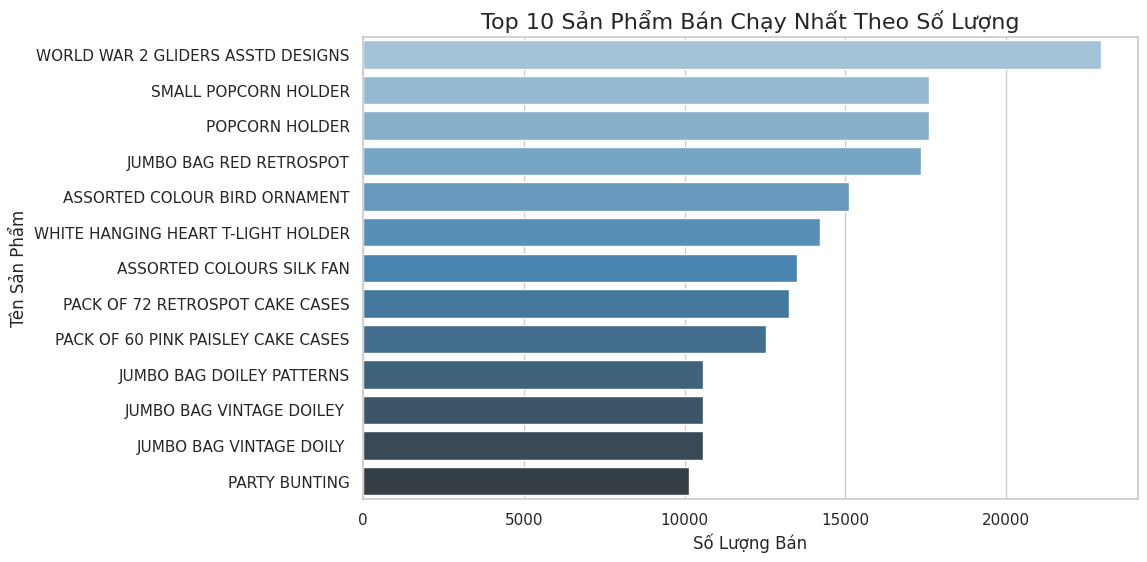

In [ ]:
# Thiết lập kiểu hiển thị đồ họa
sns.set(style="whitegrid")

# Vẽ bar chart
plt.figure(figsize=(10,6))
sns.barplot(data=top_10_products_info, x='TotalQuantity', y='Description', palette='Blues_d')

# Thêm tiêu đề và nhãn cho đồ thị
plt.title('Top 10 Sản Phẩm Bán Chạy Nhất Theo Số Lượng', fontsize=16)
plt.xlabel('Số Lượng Bán', fontsize=12)
plt.ylabel('Tên Sản Phẩm', fontsize=12)

# Hiển thị đồ thị
plt.show()

**Xét theo TotalPrice**

In [ ]:
# Tính tổng TotalPrice cho mỗi StockCode
top_products_by_totalsales = df.groupby('StockCode').agg(
    TotalSales=('TotalPrice', 'sum')  # Tính tổng TotalPrice cho mỗi StockCode
).reset_index()

# Lấy top 10 sản phẩm có tổng giá trị bán hàng cao nhất
top_10_products_sales = top_products_by_totalsales.sort_values('TotalSales', ascending=False).head(10)

# Kết hợp với thông tin Description từ df
top_10_products_info = pd.merge(top_10_products_sales, df[['StockCode', 'Description']].drop_duplicates(), on='StockCode', how='left')

# In ra kết quả
print(top_10_products_info[['StockCode', 'Description', 'TotalSales']])


   StockCode                         Description  TotalSales
0      22423            REGENCY CAKESTAND 3 TIER    53537.15
1      47566                       PARTY BUNTING    45570.05
2      22502          PICNIC BASKET WICKER SMALL    43556.95
3      22502      PICNIC BASKET WICKER 60 PIECES    43556.95
4     85123A  WHITE HANGING HEART T-LIGHT HOLDER    38477.19
5       POST                             POSTAGE    32776.01
6     85099B             JUMBO BAG RED RETROSPOT    32707.44
7      23298                      SPOTTY BUNTING    25451.20
8      23298                   BUNTING , SPOTTY     25451.20
9      84879       ASSORTED COLOUR BIRD ORNAMENT    24019.48
10     23203           JUMBO BAG DOILEY PATTERNS    20286.66
11     23203           JUMBO BAG VINTAGE DOILEY     20286.66
12     23203            JUMBO BAG VINTAGE DOILY     20286.66
13         M                              Manual    19719.83


<ipython-input-31-08b4ce567d74>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_products_info, x='TotalSales', y='Description', palette='Blues_d')


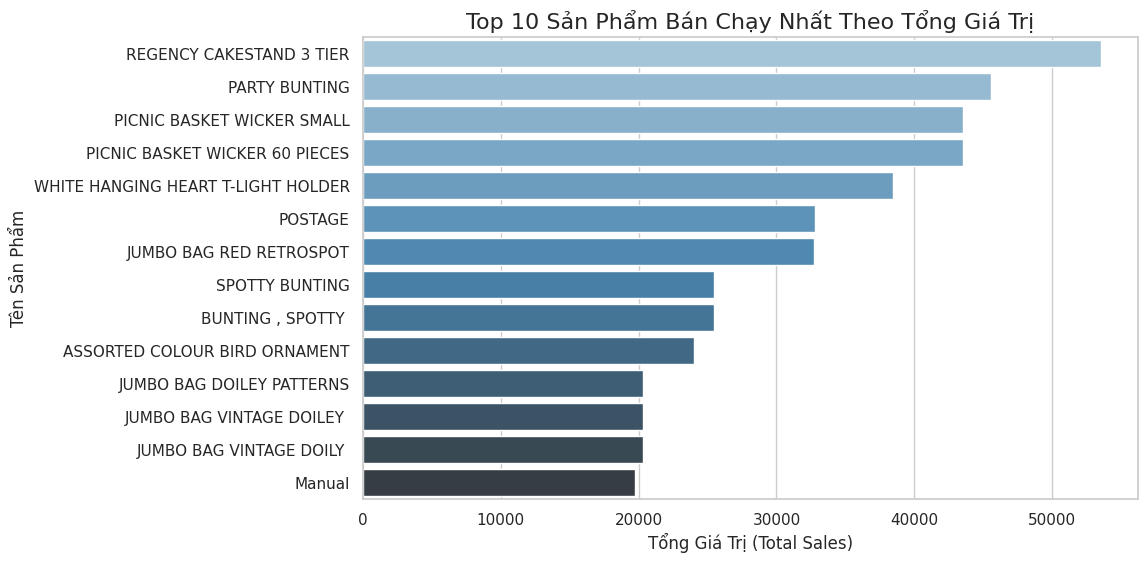

In [ ]:
# Thiết lập kiểu hiển thị đồ họa
sns.set(style="whitegrid")

# Vẽ bar chart cho top 10 sản phẩm theo TotalSales
plt.figure(figsize=(10,6))
sns.barplot(data=top_10_products_info, x='TotalSales', y='Description', palette='Blues_d')

# Thêm tiêu đề và nhãn cho đồ thị
plt.title('Top 10 Sản Phẩm Bán Chạy Nhất Theo Tổng Giá Trị', fontsize=16)
plt.xlabel('Tổng Giá Trị (Total Sales)', fontsize=12)
plt.ylabel('Tên Sản Phẩm', fontsize=12)

# Hiển thị đồ thị
plt.show()

**Xét theo cả 2 yếu tố**

In [ ]:
# Nhóm theo StockCode và tính tổng Quantity và TotalPrice cho mỗi sản phẩm
df_stock = df.groupby('StockCode').agg(
    TotalQuantity=('Quantity', 'sum'),  # Tổng số lượng bán
    TotalSales=('TotalPrice', 'sum')   # Tổng doanh thu
).reset_index()
df_stock.sort_values('TotalSales', ascending=False).head(5)

,StockCode,TotalQuantity,TotalSales
1135,22423,4651,53537.15
2090,47566,10127,45570.05
1209,22502,792,43556.95
2879,85123A,14203,38477.19
3100,POST,1058,32776.01


In [ ]:
# Kết hợp với thông tin Description từ df
top_10_products_both = pd.merge(df_stock, df[['StockCode', 'Description']].drop_duplicates(), on='StockCode', how='left')
top_10_products_both[['StockCode', 'Description', 'TotalSales','TotalQuantity']].sort_values('TotalSales', ascending=False).head(5)


,StockCode,Description,TotalSales,TotalQuantity
1146,22423,REGENCY CAKESTAND 3 TIER,53537.15,4651
2197,47566,PARTY BUNTING,45570.05,10127
1220,22502,PICNIC BASKET WICKER SMALL,43556.95,792
1221,22502,PICNIC BASKET WICKER 60 PIECES,43556.95,792
2994,85123A,WHITE HANGING HEART T-LIGHT HOLDER,38477.19,14203


### **Cách 2:**
> In ra top 5 sản phẩm tính theo mỗi tháng dựa vào doanh thu

In [ ]:
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,TotalPrice,YearMonth
142083,548550,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2011-04-01 08:22:00,1.65,18161,United Kingdom,4,16.5,2011-04
142084,548550,22296,HEART IVORY TRELLIS LARGE,12,2011-04-01 08:22:00,1.65,18161,United Kingdom,4,19.8,2011-04
142085,548550,21790,VINTAGE SNAP CARDS,12,2011-04-01 08:22:00,0.85,18161,United Kingdom,4,10.2,2011-04


In [ ]:
monthly_revenue = df.groupby(['YearMonth', 'Description'])['TotalPrice'].sum().reset_index()

In [ ]:
monthly_revenue['Rank'] = monthly_revenue.groupby('YearMonth')['TotalPrice']\
                                         .rank(method='first', ascending=False)

top3_per_month = monthly_revenue[monthly_revenue['Rank'] <= 3]
top3_per_month.head(20)

,YearMonth,Description,TotalPrice,Rank
1235,2011-04,Manual,10108.50,2.0
1606,2011-04,REGENCY CAKESTAND 3 TIER,12721.50,1.0
2115,2011-04,WHITE HANGING HEART T-LIGHT HOLDER,9581.65,3.0
3604,2011-05,PARTY BUNTING,13408.25,1.0
3750,2011-05,POSTAGE,13358.75,2.0
3854,2011-05,REGENCY CAKESTAND 3 TIER,11503.60,3.0
5911,2011-06,PARTY BUNTING,8266.15,2.0
5946,2011-06,PICNIC BASKET WICKER 60 PIECES,39619.50,1.0
6169,2011-06,REGENCY CAKESTAND 3 TIER,8216.35,3.0
8264,2011-07,PARTY BUNTING,10311.15,2.0


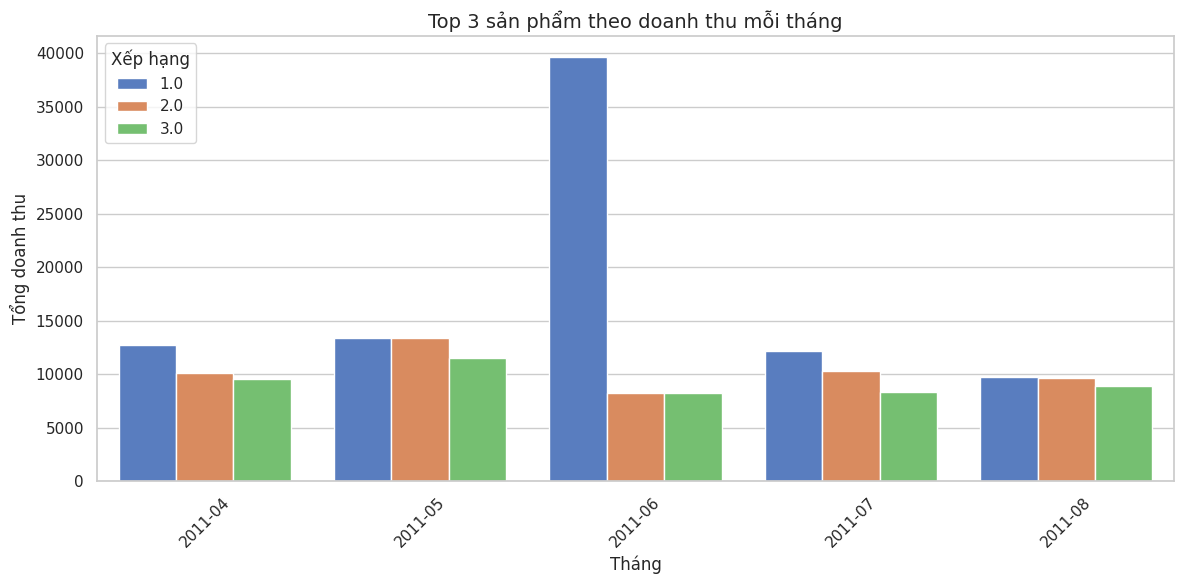

In [ ]:
# Bước 5: Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.barplot(data=top3_per_month, x='YearMonth', y='TotalPrice', hue='Rank', palette='muted')

plt.title("Top 3 sản phẩm theo doanh thu mỗi tháng", fontsize=14)
plt.ylabel("Tổng doanh thu", fontsize=12)
plt.xlabel("Tháng", fontsize=12)
plt.legend(title='Xếp hạng', loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



**Correlation giữa Quanity và TotalSales**

In [ ]:
correlation = df_stock['TotalQuantity'].corr(df_stock['TotalSales'], method='pearson')
print(f"Độ tương quan Pearson giữa Tổng Số Lượng Bán và Tổng Doanh Thu là: {correlation:.4f}")

Độ tương quan Pearson giữa Tổng Số Lượng Bán và Tổng Doanh Thu là: 0.6335


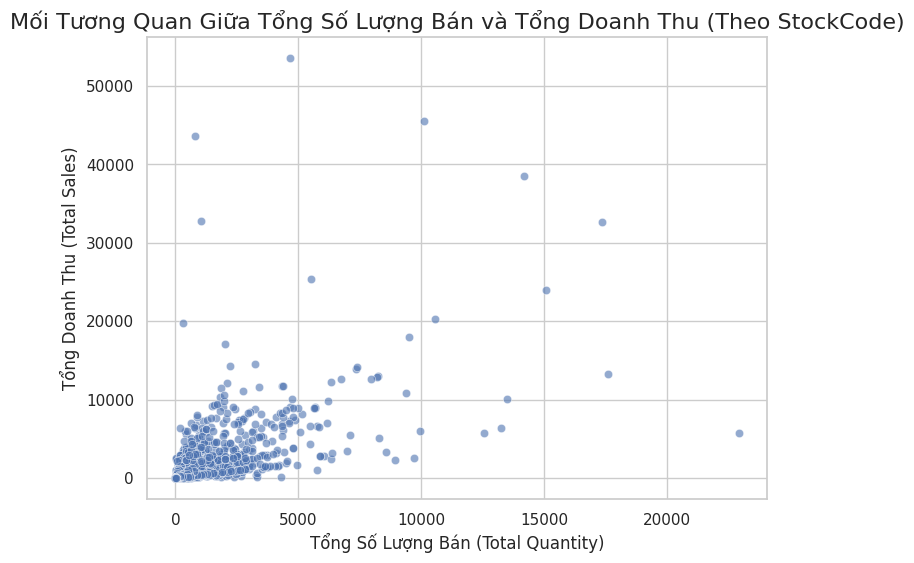

In [ ]:
# Scatter plot giữa TotalQuantity và TotalSales
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_stock, x='TotalQuantity', y='TotalSales', alpha=0.6)

# Thêm tiêu đề và nhãn cho đồ thị
plt.title('Mối Tương Quan Giữa Tổng Số Lượng Bán và Tổng Doanh Thu (Theo StockCode)', fontsize=16)
plt.xlabel('Tổng Số Lượng Bán (Total Quantity)', fontsize=12)
plt.ylabel('Tổng Doanh Thu (Total Sales)', fontsize=12)

# Hiển thị đồ thị
plt.show()

**Notes:**
+ Đa phần các đơn hàng có số lượng bán thấp (dưới 5000) và có doanh thu cũng mức thấp (dưới 10000 bảng Anh)
+ Tuy nhiên vẫn có những giá trị outliers, ví dụ như là có 1 đơn hàng số lượng chỉ hơn 4000 nhưng giá trị cao gần 60000 đồng bảng Anh)

## **Tần suất và giá trị mua hàng trung bình**

### **Cách 1:**
> Dựa trên số InvoiceNo duy nhất (unique)
> Chỉ tính số lần khách hàng thực sự mua hàng, không quan tâm thời gian, miễn là đơn hàng có InvoiceNo khác nhau.

In [ ]:
df.head(4)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,TotalPrice,YearMonth
142083,548550,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2011-04-01 08:22:00,1.65,18161,United Kingdom,4,16.5,2011-04
142084,548550,22296,HEART IVORY TRELLIS LARGE,12,2011-04-01 08:22:00,1.65,18161,United Kingdom,4,19.8,2011-04
142085,548550,21790,VINTAGE SNAP CARDS,12,2011-04-01 08:22:00,0.85,18161,United Kingdom,4,10.2,2011-04
142086,548550,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2011-04-01 08:22:00,9.95,18161,United Kingdom,4,19.9,2011-04


In [ ]:
# Tính tần suất (số lượng InvoiceNo duy nhất) và giá trị mua hàng trung bình
df_customer = df.groupby('CustomerID').agg(
    Frequency=('InvoiceNo', 'nunique'),  # Đếm số lượng InvoiceNo duy nhất
    TotalPrice=('TotalPrice', 'sum')     # Tính tổng giá trị TotalPrice
).reset_index()
df_customer.sort_values(by='Frequency', ascending=False).head(5)

,CustomerID,Frequency,TotalPrice
195,12748,71,7189.97
1126,14911,68,49590.23
2356,17841,47,15322.70
329,13089,39,18980.22
990,14606,35,4116.56


In [ ]:
# Tính giá trị mua hàng trung bình (Avg_Monetary)
df_customer['Avg_Monetary'] = df_customer['TotalPrice'] / df_customer['Frequency']
# In ra kết quả (Xếp theo Frequency giảm dần)
print(df_customer[['CustomerID', 'Frequency', 'Avg_Monetary']].sort_values(by='Frequency', ascending=False).head())
# In ra kết quả (Xếp theo Avg_Monetary giảm dần)
print(df_customer[['CustomerID', 'Frequency', 'Avg_Monetary']].sort_values(by='Avg_Monetary',ascending=False).head())

      CustomerID  Frequency  Avg_Monetary
195        12748         71    101.267183
1126       14911         68    729.268088
2356       17841         47    326.014894
329        13089         39    486.672308
990        14606         35    117.616000
      CustomerID  Frequency  Avg_Monetary
1476       15749          1  21535.900000
1202       15098          3  13305.500000
33         12415          9   6811.491111
29         12409          1   6207.080000
112        12590          2   4932.130000


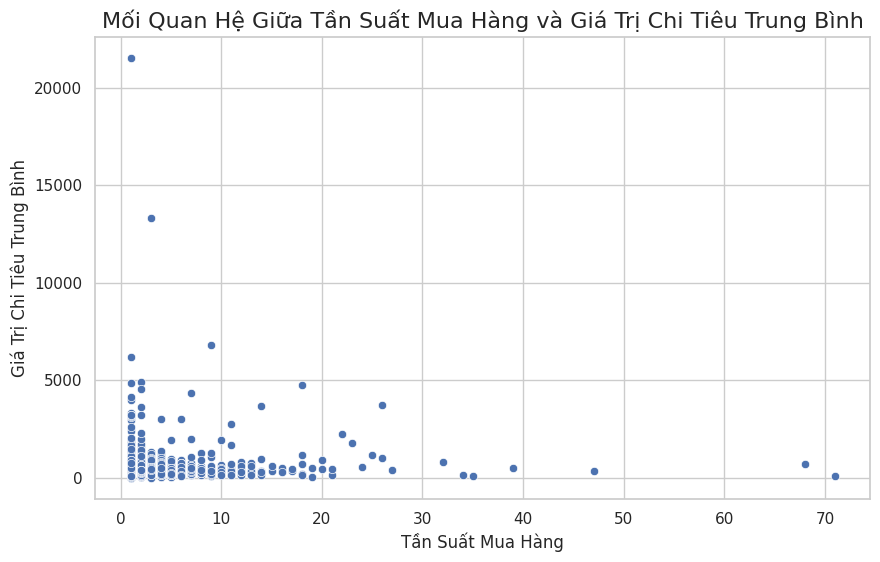

In [ ]:
# Vẽ scatter plot giữa Frequency và Avg_Monetary
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_customer, x='Frequency', y='Avg_Monetary')

# Thêm tiêu đề và nhãn
plt.title('Mối Quan Hệ Giữa Tần Suất Mua Hàng và Giá Trị Chi Tiêu Trung Bình',
          fontsize=16)
plt.xlabel('Tần Suất Mua Hàng', fontsize=12)
plt.ylabel('Giá Trị Chi Tiêu Trung Bình', fontsize=12)

# Hiển thị đồ thị
plt.show()


**Notes:**
+ Phần lớn khách hàng có tần suất mua hàng thấp (nhiều nhất trong khoảng 1-5 lần) và giá trị chi tiêu trung bình tập trung nhiều trong khoảng (0-5000 bảng Anh)
+ Vẫn xuất hiện 1 vài giá trị outliers

### **Cách 2:**
> Dựa trên số ngày mà khách hàng có giao dịch
> Chỉ quan tâm đến ngày khách quay lại mua, dù một ngày có mua bao nhiêu đơn thì cũng chỉ tính 1 lần.

In [ ]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,TotalPrice,YearMonth
142083,548550,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2011-04-01 08:22:00,1.65,18161,United Kingdom,4,16.5,2011-04
142084,548550,22296,HEART IVORY TRELLIS LARGE,12,2011-04-01 08:22:00,1.65,18161,United Kingdom,4,19.8,2011-04


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130802 entries, 142083 to 320692
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    130802 non-null  object        
 1   StockCode    130802 non-null  object        
 2   Description  130802 non-null  object        
 3   Quantity     130802 non-null  int64         
 4   InvoiceDate  130802 non-null  datetime64[ns]
 5   UnitPrice    130802 non-null  float64       
 6   CustomerID   130802 non-null  int64         
 7   Country      130802 non-null  object        
 8   Month        130802 non-null  int32         
 9   TotalPrice   130802 non-null  float64       
 10  YearMonth    130802 non-null  period[M]     
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(4), period[M](1)
memory usage: 11.5+ MB


In [ ]:
num_unique_invoices = df['InvoiceNo'].nunique()
print(f"Số lượng giá trị duy nhất trong cột 'InvoiceNo' là: {num_unique_invoices}")
num_unique_customerid = df['CustomerID'].nunique()
print(f"Số lượng giá trị duy nhất trong cột 'CustomerID' là: {num_unique_customerid}")

Số lượng giá trị duy nhất trong cột 'InvoiceNo' là: 6708
Số lượng giá trị duy nhất trong cột 'CustomerID' là: 2544


In [ ]:
df_grouped = df[['CustomerID', 'InvoiceNo']].drop_duplicates()
df_grouped = df_grouped.sort_values(by='CustomerID')
df_grouped.head(10)

,CustomerID,InvoiceNo
220572,12347,556201
286621,12347,562032
148285,12347,549222
146013,12348,548955
197371,12353,553900
166267,12354,550911
181140,12355,552449
150432,12356,549435
259735,12358,559707
212384,12359,555477


**Các bước làm**

In [ ]:
# Bước 1: Tạo cột chỉ chứa ngày (bỏ phần giờ phút giây nếu có)
df['InvoiceDay'] = df['InvoiceDate'].dt.date
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,TotalPrice,YearMonth,InvoiceDay
142083,548550,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2011-04-01 08:22:00,1.65,18161,United Kingdom,4,16.5,2011-04,2011-04-01
142084,548550,22296,HEART IVORY TRELLIS LARGE,12,2011-04-01 08:22:00,1.65,18161,United Kingdom,4,19.8,2011-04,2011-04-01
142085,548550,21790,VINTAGE SNAP CARDS,12,2011-04-01 08:22:00,0.85,18161,United Kingdom,4,10.2,2011-04,2011-04-01
142086,548550,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2011-04-01 08:22:00,9.95,18161,United Kingdom,4,19.9,2011-04,2011-04-01
142087,548550,22393,PAPERWEIGHT VINTAGE COLLAGE,6,2011-04-01 08:22:00,2.55,18161,United Kingdom,4,15.3,2011-04,2011-04-01


**Notes:** Đối với thông tin mỗi hàng, thì hàng nào có các khung giờ khác nhau nhưng cùng ngày thì vẫn được quy đổi thành 1 ngày

In [ ]:
# Bước 2: Nhóm theo CustomerID và đếm số ngày duy nhất
df_day_freq = df.groupby('CustomerID')['InvoiceDay'].nunique().reset_index()
df_day_freq.head(5)

,CustomerID,InvoiceDay
0,12347,3
1,12348,1
2,12353,1
3,12354,1
4,12355,1


In [ ]:
# Bước 3: Tính tổng chi tiêu (TotalPrice) theo CustomerID
df_total = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()

# Bước 4: Gộp 2 bảng lại để tính giá trị mua hàng trung bình
df_summary = pd.merge(df_day_freq, df_total, on='CustomerID')

# Bước 5: Tính giá trị mua hàng trung bình theo ngày
df_summary['Avg_Monetary_by_day'] = df_summary['TotalPrice'] / df_summary['InvoiceDay']

# Bước 6: Đổi tên cột cho rõ ràng hơn
df_summary.rename(columns={'InvoiceDay': 'Frequency_by_day'}, inplace=True)
# Xem kết quả
df_summary[['CustomerID', 'Frequency_by_day', 'Avg_Monetary_by_day']].sort_values(by='Frequency_by_day', ascending=False).head()




,CustomerID,Frequency_by_day,Avg_Monetary_by_day
1126,14911,49,1012.045510
2356,17841,45,340.504444
195,12748,42,171.189762
990,14606,33,124.744242
1306,15311,31,830.951935


In [ ]:
print(df_summary['CustomerID'].dtype)

int64


> **Các bước kiểm tra lại**

In [ ]:
df_summary['CustomerID'] = df_summary['CustomerID'].astype(int)

In [ ]:
df_summary['CustomerID'].isnull().sum()

np.int64(0)

In [ ]:
print("Cách 1 - Tính theo số lượng InvoiceNo:")
print(df_customer[df_customer['CustomerID'] == 17735][['CustomerID', 'Frequency', 'Avg_Monetary']])

print("\nCách 2 - Tính theo số ngày mua:")
print(df_summary[df_summary['CustomerID'] == 17735][['CustomerID', 'Frequency_by_day', 'Avg_Monetary_by_day']])

Cách 1 - Tính theo số lượng InvoiceNo:
      CustomerID  Frequency  Avg_Monetary
2318       17735         11    697.404545

Cách 2 - Tính theo số ngày mua:
      CustomerID  Frequency_by_day  Avg_Monetary_by_day
2318       17735                10              767.145


In [ ]:
df[df['CustomerID'] == 17735][['CustomerID','InvoiceNo', 'InvoiceDate', 'TotalPrice']]\
    .drop_duplicates(subset='InvoiceNo')\
    .sort_values('InvoiceDate')\
    .reset_index(drop=True)


,CustomerID,InvoiceNo,InvoiceDate,TotalPrice
0,17735,549281,2011-04-07 13:19:00,30.0
1,17735,550015,2011-04-14 10:54:00,19.8
2,17735,550997,2011-04-26 09:04:00,20.8
3,17735,551983,2011-05-05 14:32:00,19.9
4,17735,555545,2011-06-05 13:08:00,19.8
5,17735,555546,2011-06-05 13:09:00,20.8
6,17735,558195,2011-06-27 12:32:00,35.4
7,17735,559364,2011-07-08 08:48:00,20.8
8,17735,560571,2011-07-19 14:29:00,10.0
9,17735,562276,2011-08-04 10:23:00,19.5


**Notes:** Ngày 2011-06-05 khách hàng này mua 2 đơn hàng tuy nhiên theo cách 1 thì Frequency by day sẽ =2 còn theo cách 2 sẽ sẽ chỉ được tính =1 (vì mua 2 đơn hàng khác nhau, ở trong 2 khung giờ khác nhau nhưng trong cùng 1 ngày)

# **Yêu cầu 2: Xây dựng hệ thống gợi ý**

## **User-based filtering: Dựa trên khách hàng tương tự**

**Bước 1: Đọc data (đã được làm sạch)**

In [ ]:
# Chọn các cột cần thiết
df_yc2 = df[['CustomerID', 'StockCode', 'Quantity']]
df_yc2.head(4)

,CustomerID,StockCode,Quantity
142083,18161,22662,10
142084,18161,22296,12
142085,18161,21790,12
142086,18161,22622,2


**Bước 2: Tạo ma trận Customer x Item**

In [ ]:
# Chuyển dữ liệu thành dạng ma trận: Customer x Item
user_item_matrix = df_yc2.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', fill_value=0)
user_item_matrix.head()

StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214N,90214P,90214V,90214Y,BANK CHARGES,C2,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Bước 3: Tạo ma trận độ tương quan giữa những khách hàng**

In [ ]:
# Tính độ tương quan giữa những khách hàng
user_similarity = user_item_matrix.T.corr()
user_similarity.head()

CustomerID,12347,12348,12353,12354,12355,12356,12358,12359,12360,12362,...,18260,18262,18263,18265,18268,18272,18281,18282,18283,18287
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,1.000000,0.455205,-0.001861,0.000150,0.754132,0.036851,-0.003116,0.034077,0.054596,0.003279,...,-0.001419,0.005968,0.003615,0.018213,-0.001019,-0.000213,-0.002306,-0.001531,0.011335,0.219967
12348,0.455205,1.000000,-0.001089,-0.003294,0.683745,-0.001937,-0.001403,-0.003417,-0.004001,-0.003997,...,-0.002459,-0.001915,0.062963,-0.002334,-0.000596,-0.003996,-0.001349,-0.000896,0.228790,0.277798
12353,-0.001861,-0.001089,1.000000,-0.003255,0.005016,-0.001914,0.009373,-0.003377,-0.004200,-0.004134,...,-0.002430,-0.001893,-0.003748,-0.002306,-0.000589,-0.003949,-0.001333,-0.000886,-0.004531,-0.002551
12354,0.000150,-0.003294,-0.003255,1.000000,-0.003640,0.011057,-0.005451,0.008252,0.133080,0.025577,...,-0.003330,0.012679,0.006893,-0.006976,-0.001782,-0.010827,-0.003597,-0.002679,0.038063,-0.007718
12355,0.754132,0.683745,0.005016,-0.003640,1.000000,0.002045,-0.002015,0.003350,0.054447,-0.001341,...,0.004940,-0.002116,0.057819,-0.001984,-0.000659,-0.004416,-0.001491,-0.000990,0.211719,0.220389


**Bước 4: Xác định những khách hàng tương tự**
+ Bây giờ hãy sử dụng khách hàng có ID là 18282 làm ví dụ để minh họa cách tìm
những khách hàng giống nhau.

+ Loại bỏ khách hàng ID 18282 khỏi danh sách khách hàng tương tự và xác định số lượng khách hàng tương tự cần tìm

In [ ]:
#Chọn 1 khách hàng bất kỳ
customer_id=18282
# Loại bỏ ID khách hàng đấy
user_similarity.drop(index=customer_id, inplace=True)
user_similarity.head()

CustomerID,12347,12348,12353,12354,12355,12356,12358,12359,12360,12362,...,18260,18262,18263,18265,18268,18272,18281,18282,18283,18287
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,1.000000,0.455205,-0.001861,0.000150,0.754132,0.036851,-0.003116,0.034077,0.054596,0.003279,...,-0.001419,0.005968,0.003615,0.018213,-0.001019,-0.000213,-0.002306,-0.001531,0.011335,0.219967
12348,0.455205,1.000000,-0.001089,-0.003294,0.683745,-0.001937,-0.001403,-0.003417,-0.004001,-0.003997,...,-0.002459,-0.001915,0.062963,-0.002334,-0.000596,-0.003996,-0.001349,-0.000896,0.228790,0.277798
12353,-0.001861,-0.001089,1.000000,-0.003255,0.005016,-0.001914,0.009373,-0.003377,-0.004200,-0.004134,...,-0.002430,-0.001893,-0.003748,-0.002306,-0.000589,-0.003949,-0.001333,-0.000886,-0.004531,-0.002551
12354,0.000150,-0.003294,-0.003255,1.000000,-0.003640,0.011057,-0.005451,0.008252,0.133080,0.025577,...,-0.003330,0.012679,0.006893,-0.006976,-0.001782,-0.010827,-0.003597,-0.002679,0.038063,-0.007718
12355,0.754132,0.683745,0.005016,-0.003640,1.000000,0.002045,-0.002015,0.003350,0.054447,-0.001341,...,0.004940,-0.002116,0.057819,-0.001984,-0.000659,-0.004416,-0.001491,-0.000990,0.211719,0.220389


In [ ]:
# Chọn số lượng khách hàng tương tự
n = 5
# Cho ngưỡng tương quan = 0.3
user_similarity_threshold = 0.3
# Lấy 5 khách hàng có độ tương quan cao nhất
similar_users = user_similarity[user_similarity[customer_id]>user_similarity_threshold][customer_id].sort_values(ascending=False).iloc[:n]
# Print out top n similar users
print(f'Những khách hàng tương tự với khách hàng {customer_id} là', similar_users)

Những khách hàng tương tự với khách hàng 18282 là CustomerID
15671    0.842782
13269    0.579447
15628    0.554245
14916    0.531256
17229    0.447403
Name: 18282, dtype: float64


**Bước 5: Thu hẹp tập hợp sản phẩm:**

+ Loại bỏ những sản phẩm mà khách hàng 18282 đã mua và giữ lại những sản phẩm khách hàng tương tự đã mua

In [ ]:
# Xác định sản phẩm mà khách hàng đã mua
picked_userid_bought = user_item_matrix[user_item_matrix.index == customer_id]
# Xác định các cột có tất cả giá trị là 0
cols_to_drop = picked_userid_bought.columns[(picked_userid_bought == 0).all()]
# Loại bỏ các sản phẩm mà khách hàng 18282 chưa mua
picked_userid_bought = picked_userid_bought.drop(cols_to_drop, axis=1)
picked_userid_bought

StockCode,21108,21109,21270,22089,22424,23187,23295
CustomerID,,,,,,,
18282,9.0,2.0,1.0,6.0,1.0,48.0,8.0


In [ ]:
# Những sản phẩm mà khách hàng tương tự đã mua
similar_user_items = user_item_matrix[user_item_matrix.index.isin(similar_users.index)]

# Lấy danh sách các cột mà tất cả giá trị đều là 0
cols_to_drop = similar_user_items.columns[(similar_user_items == 0).all()]

# Loại bỏ các sản phẩm mà những khách hàng tương tự chưa mua
similar_user_items = similar_user_items.drop(cols_to_drop, axis=1)
similar_user_items

StockCode,20711,20724,20728,20971,20972,20984,21084,21090,21137,21166,...,47591D,79190B,82494L,84313C,84596B,84751B,85099B,85099F,85123A,85199L
CustomerID,,,,,,,,,,,,,,,,,,,,,
13269,0.0,0.0,0.0,0.0,0.0,0.0,19.0,4.0,5.333333,0.0,...,0.0,9.0,15.0,4.0,16.0,2.0,10.0,0.0,3.0,0.0
14916,0.0,10.0,0.0,0.0,0.0,24.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15628,0.0,0.0,0.0,12.0,12.0,0.0,0.0,0.0,0.000000,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
15671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
17229,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,2.0,0.0,0.0


In [ ]:
# Bỏ sản phẩm khách hàng đã mua
similar_user_items.drop(picked_userid_bought.columns,axis=1, inplace=True, errors='ignore')
similar_user_items

StockCode,20711,20724,20728,20971,20972,20984,21084,21090,21137,21166,...,47591D,79190B,82494L,84313C,84596B,84751B,85099B,85099F,85123A,85199L
CustomerID,,,,,,,,,,,,,,,,,,,,,
13269,0.0,0.0,0.0,0.0,0.0,0.0,19.0,4.0,5.333333,0.0,...,0.0,9.0,15.0,4.0,16.0,2.0,10.0,0.0,3.0,0.0
14916,0.0,10.0,0.0,0.0,0.0,24.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15628,0.0,0.0,0.0,12.0,12.0,0.0,0.0,0.0,0.000000,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
15671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
17229,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,2.0,0.0,0.0


**Bước 6: Đề xuất sản phẩm nào cho khách hàng mục tiêu:**

Các mục được đề xuất được xác định dựa điểm gợi ý trung bình cho từng sản phẩm dựa trên số lượng mua và độ tương quan giữa khách hàng. Đoạn mã này sẽ lặp qua các mục và khách hàng để tính điểm cho từng sản phẩm, sau đó sắp xếp điểm từ cao đến thấp và chọn ra 10 sản phẩm có điểm cao nhất để đề xuất cho khách hàng có ID là 18282.



In [ ]:
# Tạo 1 dictionary lưu trữ điểm số dự đoán của từng sản phẩm
item_score = {}
# Tạo vòng lặp sản phẩm
for i in similar_user_items.columns:
  # Số lượng mua của tất cả khách hàng tương tự đối với sản phẩm i
  item_quantity = similar_user_items[i]
  # Tạo 1 biến để tổng hợp số lượng mua
  total = 0
  # Tạo 1 biến để đếm số lượng khách hàng đã mua sản phẩm i
  count = 0
  # Tạo vòng lặp khách hàng tương tự
  for u in similar_users.index:
    # Nếu đã mua sản phẩm
    if item_quantity[u] != 0:
      # Tổng điểm tương đồng của khách hàng nhân với số lượng mua
      score = similar_users[u] * item_quantity[u]
      # Cộng điểm số vừa tính được vào tổng điểm số của sản phẩm i
      total += score
      # Tăng biến count lên 1
      count +=1
  # Điểm số dự đoán trung bình cho sản phẩm i
  item_score[i] = total / count
# Chuyển dictionary item_score thành một DataFrame Pandas có hai cột: 'StockCode' (chứa StockCode) và 'item_score' (chứa điểm số dự đoán)
item_score = pd.DataFrame(item_score.items(), columns=['StockCode', 'item_score'])

# Sắp xếp DataFrame item_score theo cột 'item_score' theo thứ tự giảm dần
ranked_item_score = item_score.sort_values(by='item_score', ascending=False)
# Chọn top 10 sản phẩm
ranked_item_score = item_score.sort_values(by='item_score', ascending=False).head(10)
# Lấy danh sách StockCode của top 10 sản phẩm
top_10_stock_codes = ranked_item_score['StockCode'].tolist()
# Lấy thông tin Description tương ứng từ DataFrame gốc (df)
top_10_descriptions = df[df['StockCode'].isin(top_10_stock_codes)][['StockCode', 'Description']].drop_duplicates(subset=['StockCode'])
top_10_descriptions = top_10_descriptions.set_index('StockCode')['Description'].to_dict()
# Tạo list Description tương ứng với thứ tự StockCode trong ranked_item_score
recommendation_descriptions = [top_10_descriptions.get(stock_code, 'Không có mô tả') for stock_code in ranked_item_score['StockCode']]
# Thêm cột 'Description' vào ranked_item_score
ranked_item_score.insert(0, 'Description', recommendation_descriptions)
print(ranked_item_score)

                         Description StockCode  item_score
46   PAPER CHAIN KIT 50'S CHRISTMAS      22086   33.711269
18              RED POLKADOT BEAKER      21394   27.813463
84           MINI PAINT SET VINTAGE      22492   20.860097
106         PENS ASSORTED FUNNY FACE     22610   20.860097
47        PARTY CONES CANDY ASSORTED     22128   20.226762
101     PACK OF 6 SWEETIE GIFT BOXES     22582   20.226762
24          RIDGED GLASS FINGER BOWL     21654   19.125221
45            PAPER CHAIN KIT EMPIRE     22084   18.593976
103   PACK OF 6 PANNETONE GIFT BOXES     22584   15.170071
143                GINGHAM ROSE WRAP     22986   14.486179


### **Trực quan hóa: Vẽ biểu đồ gợi ý 5 sản phẩm cho khách hàng**

**Bước 7: Gợi ý 5 sản phẩm cho khách hàng**

<ipython-input-82-b9617599276f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_ranked_items['item_score'].values, y=top_5_ranked_items['Description'], palette='coolwarm')


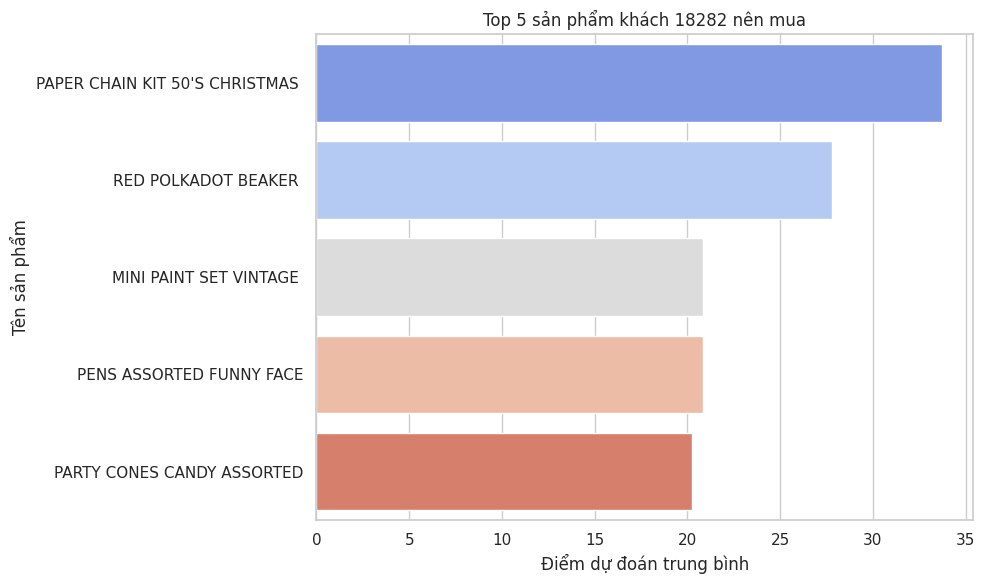

In [ ]:
# Lấy top 5 sản phẩm
top_5_ranked_items = ranked_item_score.head(5)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_ranked_items['item_score'].values, y=top_5_ranked_items['Description'], palette='coolwarm')
plt.title(f'Top 5 sản phẩm khách {customer_id} nên mua')
plt.xlabel('Điểm dự đoán trung bình')
plt.ylabel('Tên sản phẩm')
plt.tight_layout()
plt.show()

## **Apriori (Market Basket): Gợi ý sản phẩm thường mua kèm**

In [ ]:
# Xem data đã làm sạch
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,TotalPrice,YearMonth,InvoiceDay
142083,548550,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2011-04-01 08:22:00,1.65,18161,United Kingdom,4,16.5,2011-04,2011-04-01
142084,548550,22296,HEART IVORY TRELLIS LARGE,12,2011-04-01 08:22:00,1.65,18161,United Kingdom,4,19.8,2011-04,2011-04-01
142085,548550,21790,VINTAGE SNAP CARDS,12,2011-04-01 08:22:00,0.85,18161,United Kingdom,4,10.2,2011-04,2011-04-01
142086,548550,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2011-04-01 08:22:00,9.95,18161,United Kingdom,4,19.9,2011-04,2011-04-01
142087,548550,22393,PAPERWEIGHT VINTAGE COLLAGE,6,2011-04-01 08:22:00,2.55,18161,United Kingdom,4,15.3,2011-04,2011-04-01


In [ ]:
# Đếm số lượng đơn hàng (InvoiceNo) duy nhất - Hỗ trợ việc chọn min_support
so_don_hang = df['InvoiceNo'].nunique()
print(f"Tổng số đơn hàng: {so_don_hang}")

Tổng số đơn hàng: 6708


In [ ]:
#Đếm số sản phẩm (Description) duy nhất - Hỗ trợ việc chọn min_support
so_san_pham = df['Description'].nunique()
so_san_pham

3200

In [ ]:
# Top 100 sản phẩm xuất hiện nhiều nhât
top_items = df['Description'].value_counts().nlargest(100).index
print(top_items)

Index(['PARTY BUNTING', 'WHITE HANGING HEART T-LIGHT HOLDER',
       'REGENCY CAKESTAND 3 TIER', 'SPOTTY BUNTING', 'JUMBO BAG RED RETROSPOT',
       'LUNCH BAG RED RETROSPOT', 'LUNCH BAG APPLE DESIGN',
       'ASSORTED COLOUR BIRD ORNAMENT', 'LUNCH BAG SUKI DESIGN ',
       'LUNCH BAG CARS BLUE', 'LUNCH BAG PINK POLKADOT',
       'LUNCH BAG  BLACK SKULL.', 'LUNCH BAG DOILEY PATTERN ',
       'JUMBO BAG APPLES', 'JUMBO BAG DOILEY PATTERNS', 'JUMBO BAG ALPHABET',
       'LUNCH BAG ALPHABET DESIGN', 'SET OF 4 PANTRY JELLY MOULDS',
       'LUNCH BAG SPACEBOY DESIGN ', 'PACK OF 72 RETROSPOT CAKE CASES',
       'JUMBO BAG VINTAGE LEAF', 'LUNCH BAG WOODLAND', 'POSTAGE',
       'JUMBO BAG PINK POLKADOT', 'LUNCH BAG VINTAGE LEAF DESIGN',
       'WOODEN PICTURE FRAME WHITE FINISH', 'SET OF 3 REGENCY CAKE TINS',
       'VICTORIAN GLASS HANGING T-LIGHT', 'NATURAL SLATE HEART CHALKBOARD ',
       'ROSES REGENCY TEACUP AND SAUCER ',
       'COLOUR GLASS T-LIGHT HOLDER HANGING', 'JUMBO STORAGE BAG SU

#### **APRIORI LUẬT KẾT HỢP VỚI SỐ LƯỢNG SẢN PHẨM TRONG ITEMSET KHÔNG GIỚI HẠN**

In [ ]:
# Tạo bảng one-hot encoding cho các sản phẩm theo đơn hàng
# Các dòng là mã đơn hàng (InvoiceNo), các cột là mã sản phẩm (Stockcode), các ô là số lượng sản phẩm (Quantity)
basket = (df.groupby(['InvoiceNo', 'StockCode'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

# Chuyển đổi số lượng thành binary (0 hoặc 1)
#Chỉ cần sản phẩm có xuất hiện trong đơn thì đánh 1 không quan tâm số lượng, ngược lại đánh 0
basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)
basket_sets.head(5)

<ipython-input-87-6b9787e14b6e>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)


StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214N,90214P,90214V,90214Y,BANK CHARGES,C2,DOT,M,PADS,POST
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
548550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
548551,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
548552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
548553,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
548554,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Ý nghĩa bước này:
- Mỗi hàng tương ứng với một đơn hàng (InvoiceNo)
- Mỗi cột tương ứng với một sản phẩm (StockCode)
- Giá trị 1 nghĩa là sản phẩm đó xuất hiện trong đơn hàng, 0 nghĩa là không xuất hiện
- Thuật toán Apriori cần dữ liệu ở dạng này để xác định các tập mục phổ biến

In [ ]:
# Thử một vài giá trị min_support khác nhau để chọn ra min_support thích hợp
for min_sup in [0.03, 0.02, 0.015]:
    frequent_itemsets = apriori(basket_sets, min_support=min_sup, use_colnames=True)
    print(f"Min support: {min_sup}, số lượng itemset: {len(frequent_itemsets)}")

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Min support: 0.03, số lượng itemset: 127


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Min support: 0.02, số lượng itemset: 334


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Min support: 0.015, số lượng itemset: 672


> **Notes** Ta có với min_support = 0.02 thì sẽ cho ra 334 itemsets và mỗi itemsets xuất hiện 0.02*6708 = 134 lần. Từ đây, độ phổ biến và số lượng itemsets không quá nhiều cũng không quá ít so với data nên ta chọn con số 0.02 này làm min_support.  

In [ ]:
# Chọn giá trị min_support = 0.02 và áp dụng Apriori với min_support đã chọn
frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)
print(f"Tìm thấy {len(frequent_itemsets)} tập phổ biến")
print(frequent_itemsets.head(10))

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Tìm thấy 334 tập phổ biến
    support itemsets
0  0.028473  (15036)
1  0.030710  (20685)
2  0.029815  (20712)
3  0.023405  (20718)
4  0.032797  (20719)
5  0.036524  (20723)
6  0.044126  (20724)
7  0.089744  (20725)
8  0.057543  (20726)
9  0.067531  (20727)


In [ ]:
# Tạo luật kết hợp với min_confidence = 0.3 (Chọn confidence = 0.3)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

# Sắp xếp các luật theo lift giảm dần
rules = rules.sort_values('lift', ascending=False)

# Hiển thị 10 luật có lift cao nhất
print(rules.head(10))

        antecedents     consequents  antecedent support  consequent support  \
119         (23170)         (23171)            0.030561            0.024001   
120         (23171)         (23170)            0.024001            0.030561   
69          (21932)         (21933)            0.033244            0.030561   
70          (21933)         (21932)            0.030561            0.033244   
214         (22698)  (22697, 22699)            0.037716            0.034735   
211  (22697, 22699)         (22698)            0.034735            0.037716   
212  (22698, 22699)         (22697)            0.030710            0.043828   
213         (22697)  (22698, 22699)            0.043828            0.030710   
113         (22697)         (22698)            0.043828            0.037716   
114         (22698)         (22697)            0.037716            0.043828   

      support  confidence       lift  representativity  leverage  conviction  \
119  0.021467    0.702439  29.266838              

Thông thường confidence >= 0.6 là chấp nhận được

In [ ]:
# Tạo từ điển ánh xạ mã sản phẩm với tên sản phẩm
product_names = df[['StockCode', 'Description']].drop_duplicates()
product_dict = dict(zip(product_names['StockCode'], product_names['Description']))

# Hàm chuyển đổi từ mã sản phẩm sang tên sản phẩm
def convert_codes_to_names(itemset):
    return tuple(product_dict.get(item, str(item)) for item in itemset)

# Áp dụng cho kết quả
rules['antecedents_names'] = rules['antecedents'].apply(convert_codes_to_names)
rules['consequents_names'] = rules['consequents'].apply(convert_codes_to_names)

# Hiển thị kết quả với tên sản phẩm
print(rules[['antecedents_names', 'consequents_names', 'support', 'confidence', 'lift']].head(10))

                                     antecedents_names  \
119                        (REGENCY TEA PLATE ROSES ,)   
120                        (REGENCY TEA PLATE GREEN ,)   
69                  (SCANDINAVIAN PAISLEY PICNIC BAG,)   
70                  (PINK VINTAGE PAISLEY PICNIC BAG,)   
214                  (PINK REGENCY TEACUP AND SAUCER,)   
211  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...   
212  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
213                 (GREEN REGENCY TEACUP AND SAUCER,)   
113                 (GREEN REGENCY TEACUP AND SAUCER,)   
114                  (PINK REGENCY TEACUP AND SAUCER,)   

                                     consequents_names   support  confidence  \
119                        (REGENCY TEA PLATE GREEN ,)  0.021467    0.702439   
120                        (REGENCY TEA PLATE ROSES ,)  0.021467    0.894410   
69                  (PINK VINTAGE PAISLEY PICNIC BAG,)  0.022063    0.663677   
70                  (SCANDINAVIAN PAISLEY

In [ ]:
# Lọc các luật có lift cao (> 10) và confidence cao (> 0.7)
strong_rules = rules[(rules['lift'] > 10) & (rules['confidence'] > 0.7)]
print(f"Số luật mạnh (lift > 10, confidence > 0.5): {len(strong_rules)}")

# Hiển thị các luật mạnh nhất (Thông thường lift và confidence càng cao càng hiệu quả)
print(strong_rules[['antecedents_names', 'consequents_names', 'support', 'confidence', 'lift']].head(10))

Số luật mạnh (lift > 10, confidence > 0.5): 14
                                     antecedents_names  \
119                        (REGENCY TEA PLATE ROSES ,)   
120                        (REGENCY TEA PLATE GREEN ,)   
70                  (PINK VINTAGE PAISLEY PICNIC BAG,)   
214                  (PINK REGENCY TEACUP AND SAUCER,)   
211  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...   
212  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
113                 (GREEN REGENCY TEACUP AND SAUCER,)   
114                  (PINK REGENCY TEACUP AND SAUCER,)   
111                            (DOLLY GIRL LUNCH BOX,)   
210  (GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...   

                                     consequents_names   support  confidence  \
119                        (REGENCY TEA PLATE GREEN ,)  0.021467    0.702439   
120                        (REGENCY TEA PLATE ROSES ,)  0.021467    0.894410   
70                  (SCANDINAVIAN PAISLEY PICNIC BAG,)  0.022063    0.7219

Dựa vào các luật mạnh trên, mày có thể đưa ra combo gợi ý mua kèm như sau:
1. Combo đĩa Regency:
Nếu khách mua Regency Tea Plate Green, gợi ý thêm Regency Tea Plate Roses (và ngược lại).
Lý do: 2 sản phẩm này thường đi cùng nhau, độ tin cậy cao (~70–89%).

2. Combo túi picnic Paisley:
Gợi ý khách mua cả Scandinavian và Pink Vintage bản túi picnic.
Dễ tạo combo theo phong cách vintage hoặc pastel tone.

3. Combo tách trà Regency:
Nếu khách đã mua Pink Regency Teacup and Saucer, gợi ý bản Green Regency hoặc phiên bản có hoa hồng đi kèm.

<ipython-input-93-136d64baeca5>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-93-136d64baeca5>:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


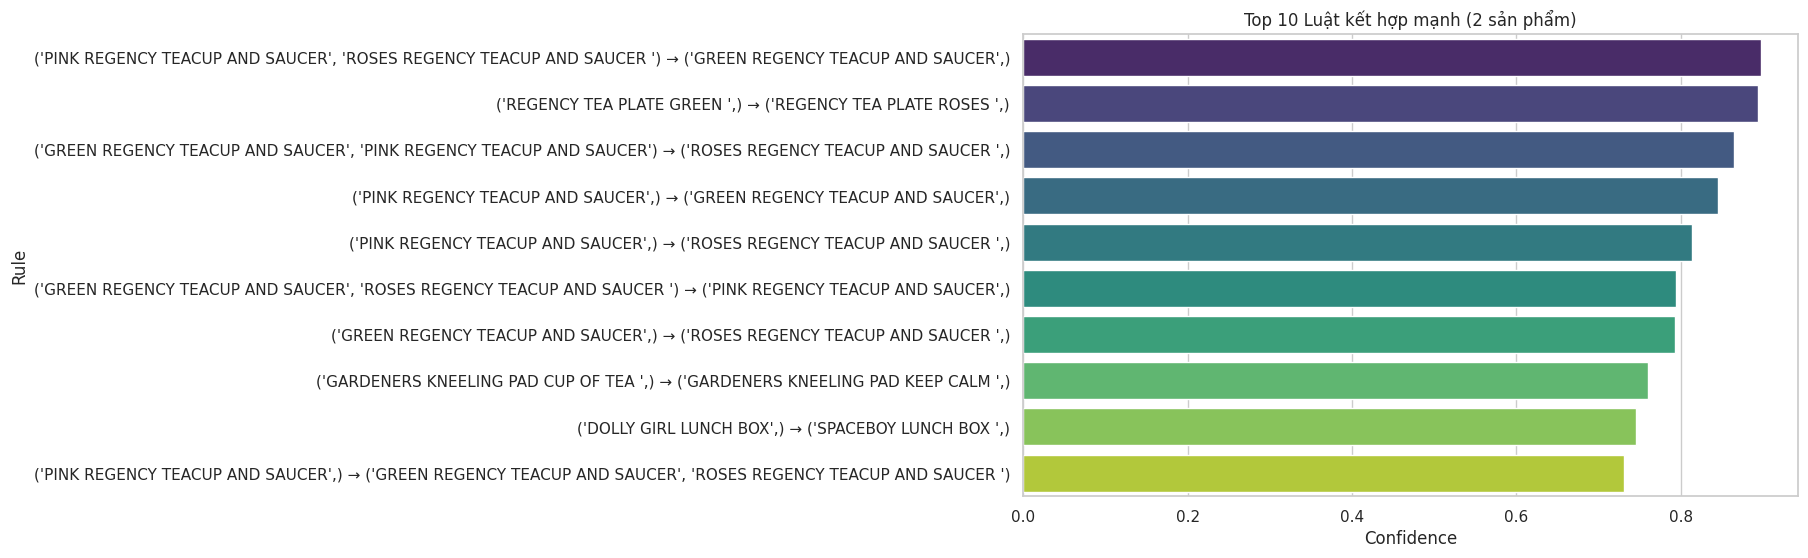

In [ ]:
#Trực quan hóa bằng biểu đồ
top_rules = strong_rules.sort_values(by='confidence', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(
    y=top_rules['antecedents_names'].astype(str) + ' → ' + top_rules['consequents_names'].astype(str),
    x=top_rules['confidence'],
    palette="viridis"
)
plt.xlabel('Confidence')
plt.ylabel('Rule')
plt.title('Top 10 Luật kết hợp mạnh (2 sản phẩm)')
plt.tight_layout()
plt.show()

#### **APRIORI LUẬT KẾT HỢP 3 SẢN PHẨM**

In [ ]:
#Lọc luật có đúng 3 sản phẩm (antecedents + consequents = 3)
rules['total_items'] = rules['antecedents'].apply(lambda x: len(x)) + rules['consequents'].apply(lambda x: len(x))
rules_3 = rules[rules['total_items'] == 3] # Ở đây có thể thay 3 bằng con số khác

#Lọc tiếp theo lift nếu muốn
rules_3_strong = rules_3[rules_3['lift'] > 10]

# Xem top 10
rules_3_strong.sort_values(by='confidence', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_names,consequents_names,total_items
212,"(22698, 22699)",(22697),0.030710,0.043828,0.027579,0.898058,20.490390,1.0,0.026233,9.379589,0.981333,0.587302,0.893386,0.763655,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...","(GREEN REGENCY TEACUP AND SAUCER,)",3
210,"(22697, 22698)",(22699),0.031902,0.050388,0.027579,0.864486,17.156722,1.0,0.025972,7.007485,0.972747,0.504087,0.857295,0.705912,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...","(ROSES REGENCY TEACUP AND SAUCER ,)",3
211,"(22697, 22699)",(22698),0.034735,0.037716,0.027579,0.793991,21.051757,1.0,0.026269,4.671086,0.986773,0.614618,0.785917,0.762608,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...","(PINK REGENCY TEACUP AND SAUCER,)",3
214,(22698),"(22697, 22699)",0.037716,0.034735,0.027579,0.731225,21.051757,1.0,0.026269,3.591355,0.989831,0.614618,0.721554,0.762608,"(PINK REGENCY TEACUP AND SAUCER,)","(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",3
213,(22697),"(22698, 22699)",0.043828,0.030710,0.027579,0.629252,20.490390,1.0,0.026233,2.614416,0.994797,0.587302,0.617505,0.763655,"(GREEN REGENCY TEACUP AND SAUCER,)","(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",3
215,(22699),"(22697, 22698)",0.050388,0.031902,0.027579,0.547337,17.156722,1.0,0.025972,2.138674,0.991682,0.504087,0.532420,0.705912,"(ROSES REGENCY TEACUP AND SAUCER ,)","(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",3


In [ ]:
#HIỆN TÊN SẢN PHẨM
# Hàm chuyển đổi từ mã sản phẩm sang tên sản phẩm
def convert_codes_to_names(itemset):
    return tuple(product_dict.get(item, str(item)) for item in itemset)

# Áp dụng cho cột 'antecedents' và 'consequents' trong rules_3_strong
rules_3_strong['antecedents_names'] = rules_3_strong['antecedents'].apply(convert_codes_to_names)
rules_3_strong['consequents_names'] = rules_3_strong['consequents'].apply(convert_codes_to_names)

# Hiển thị kết quả với tên sản phẩm
print(rules_3_strong[['antecedents_names', 'consequents_names', 'support', 'confidence', 'lift']].head(10))

                                     antecedents_names  \
214                  (PINK REGENCY TEACUP AND SAUCER,)   
211  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...   
212  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
213                 (GREEN REGENCY TEACUP AND SAUCER,)   
215                (ROSES REGENCY TEACUP AND SAUCER ,)   
210  (GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...   

                                     consequents_names   support  confidence  \
214  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...  0.027579    0.731225   
211                  (PINK REGENCY TEACUP AND SAUCER,)  0.027579    0.793991   
212                 (GREEN REGENCY TEACUP AND SAUCER,)  0.027579    0.898058   
213  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...  0.027579    0.629252   
215  (GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...  0.027579    0.547337   
210                (ROSES REGENCY TEACUP AND SAUCER ,)  0.027579    0.864486   

          lift  
214  21.051757 

<ipython-input-95-846c34c1e291>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_3_strong['antecedents_names'] = rules_3_strong['antecedents'].apply(convert_codes_to_names)
<ipython-input-95-846c34c1e291>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_3_strong['consequents_names'] = rules_3_strong['consequents'].apply(convert_codes_to_names)


<ipython-input-96-d603be4c62c9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_3_strong['rule'] = rules_3_strong['antecedents_names'].apply(lambda x: ', '.join(x)) + ' → ' + \
<ipython-input-96-d603be4c62c9>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_rules_3, y='rule', x='confidence', palette='magma')


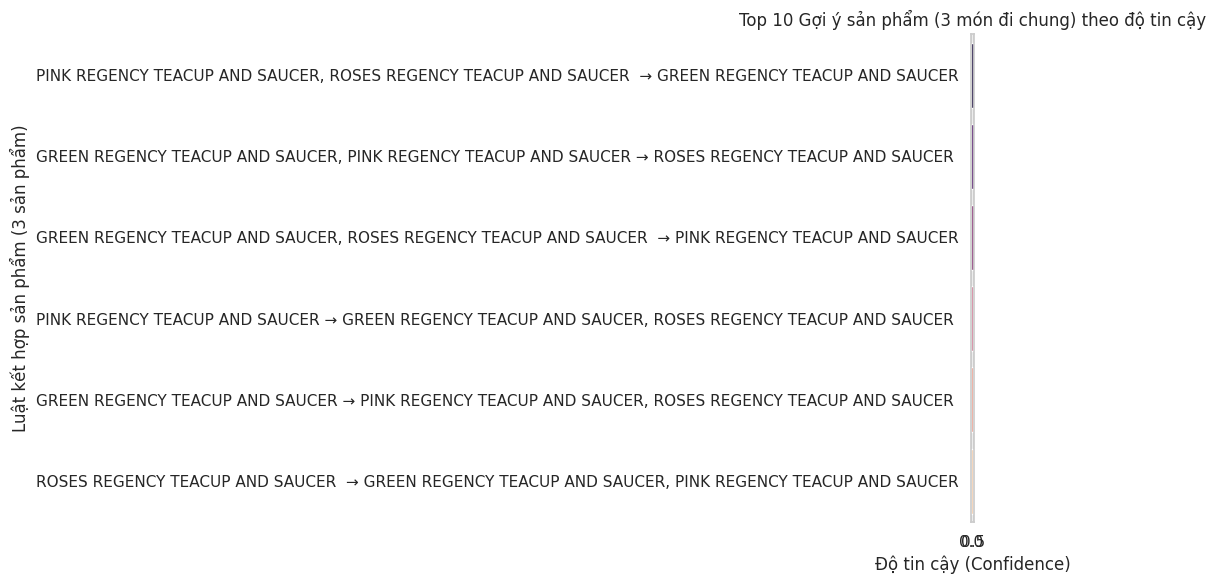

In [ ]:
# Tạo cột mô tả luật kiểu: Sản phẩm A, B → C
rules_3_strong['rule'] = rules_3_strong['antecedents_names'].apply(lambda x: ', '.join(x)) + ' → ' + \
                         rules_3_strong['consequents_names'].apply(lambda x: ', '.join(x))

# Lấy top 10 luật có confidence cao nhất
top_rules_3 = rules_3_strong.sort_values(by='confidence', ascending=False).head(10)

# Vẽ barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_rules_3, y='rule', x='confidence', palette='magma')

plt.xlabel('Độ tin cậy (Confidence)')
plt.ylabel('Luật kết hợp sản phẩm (3 sản phẩm)')
plt.title('Top 10 Gợi ý sản phẩm (3 món đi chung) theo độ tin cậy')
plt.tight_layout()
plt.show()

#### **Trực quan hóa**: Vẽ biểu đồ mạng cho sản phẩm thường đi kèm

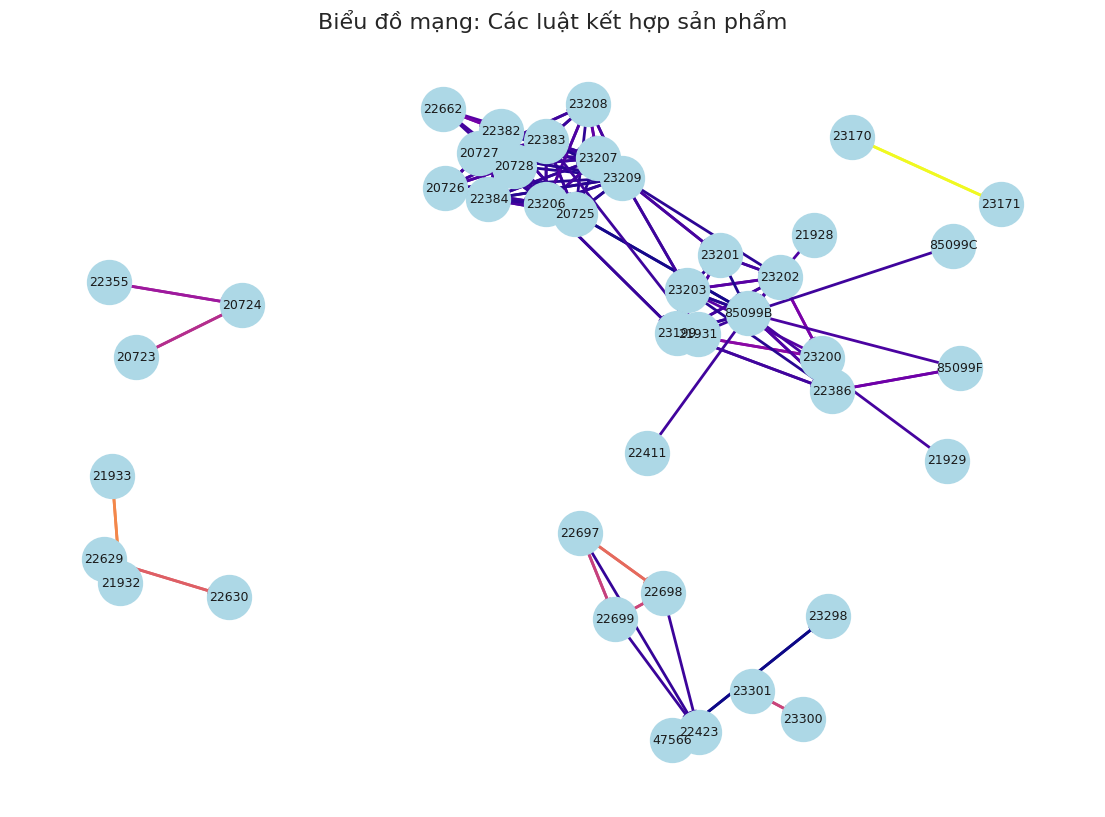

In [ ]:
# Khởi tạo đồ thị có hướng
G = nx.DiGraph()

# Duyệt qua các luật kết hợp và thêm các cạnh vào đồ thị
for _, row in rules.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])

    # Duyệt qua các sản phẩm trong antecedents và consequents, tạo cạnh giữa chúng
    for a in antecedents:
        for c in consequents:
            G.add_edge(a, c, lift=row['lift'], confidence=row['confidence'])

# Vẽ biểu đồ mạng
plt.figure(figsize=(14, 10))

# Đặt vị trí các node
pos = nx.spring_layout(G, k=0.5, seed=42)  # Layout đẹp

# Lấy trọng số của cạnh từ thuộc tính 'lift'
weights = [d['lift'] for (u, v, d) in G.edges(data=True)]

# Vẽ các node, nhãn và cạnh của đồ thị
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=9)
nx.draw_networkx_edges(G, pos, edge_color=weights, edge_cmap=plt.cm.plasma, arrows=True, width=2)

# Hiển thị tiêu đề và ẩn trục
plt.title('Biểu đồ mạng: Các luật kết hợp sản phẩm', fontsize=16)
plt.axis('off')
plt.show()

**NOTES**

Đường màu tím đậm/xanh đậm: Thường biểu thị mối quan hệ mạnh, tần suất xuất hiện cùng nhau cao, hoặc mức độ liên kết lớn.

Đường màu vàng, cam, đỏ nhạt: Thường biểu thị mối quan hệ yếu hơn, tần suất xuất hiện cùng nhau thấp hơn, hoặc mức độ liên kết nhỏ.

Các đỉnh là mã sản phẩm
Các cạnh thể hiện mức độ liên kết qua độ đậm nhạt/màu sắc của chúng.


**Nhận xét:**
- Có 2 cụm có liên kết mạnh mẽ với nhau, trong đó 1 cụm  gồm các đỉnh liên kết chặt hơn và 1 cụm có sản phẩm trung tâm nhờ có nhiều cạnh liên kết với sản phẩm khác.
- Có một vài cụm đơn lẻ xung quanh với độ liên kết yếu hơn